In [1]:
import numpy as np
import yaml
from patches_data_loader import PatchesDataLoader as PDL
import sys
sys.path.append('/home/jmahler/jacky_working/GPIS/src/grasp_selection/')
import plotting as plotting
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
config_path = '/home/jmahler/jacky_working/GPIS/cfg/patches/analyze_patch_features_config.yaml'
input_path = '/mnt/wd_ssd/projects/deep_patches/data/temp/'
output_path = '/mnt/wd_ssd/projects/deep_patches/data/temp/features'

In [3]:
def _ensure_dir_exists(dir):
    if not os.path.exists(dir):
        os.makedirs(dir)

In [4]:
with open(config_path) as config_file:
    config = yaml.safe_load(config_file)

In [17]:
num_bins = 100
line_width = 2
font_size = 20
dpi = 400
crop_dim = 3
eps = 0.0
scatter_subsamples = 10000

In [8]:
#load data
features_set_hist_bin = PDL.get_include_set_from_dict(config['feature_prefixes_hist_bin'])

features_set_scatter_pair = []
pair_configs = config['feature_prefixes_scatter_pair']
for pair_config in pair_configs:
    if pair_config['use']:
        features_set_scatter_pair.append(set(pair_config['pair']))

labels_set = PDL.get_include_set_from_dict(config['label_prefixes'])

features_set = [features_set_hist_bin]
features_set.extend(features_set_scatter_pair)
features_set = set.union(*features_set)

pdl = PDL(0.25, input_path, eval(config['file_nums']), features_set, set(), labels_set, split_by_objs=False)

In [13]:
w1_w2 = pdl.get_partial_raw_data(tuple(features_pair))
all_metrics = pdl._raw_data['ferrari_canny_L1_']
metric = 'ferrari_canny_L1_'

In [16]:
A = np.c_[w1_w2, np.ones(w1_w2.shape[0])]
b = all_metrics
w, se, rank, s = np.linalg.lstsq(A, b)
pred_metrics = A.dot(w)
pred_error = pred_metrics - all_metrics

In [18]:
inds = np.arange(w1_w2.shape[0])
if w1_w2.shape[0] > scatter_subsamples:
    inds = np.choose(scatter_subsamples, np.arange(w1_w2.shape[0]))    

In [39]:
rho = np.corrcoef(np.c_[w1_w2, all_metrics].T)

w1, w2 = w1_w2[:,0], w1_w2[:,1]
w1_sub = w1[inds]
w2_sub = w2[inds]
min_p1 = np.min(w1)
max_p1 = np.max(w1)
min_p2 = np.min(w2)
max_p2 = np.max(w2)
x_vals = [min_p1, max_p1]
y_vals = [w[2] + w[0] * min_p1 + w[1] * min_p2, w[2] + w[0] * max_p1 + w[1] * max_p2]

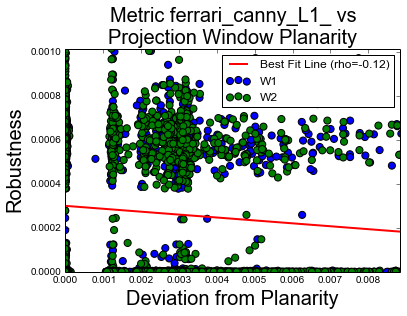

In [49]:
# NOTE FIGURE 5 of 7
plt.figure()
plt.scatter(w1[inds], all_metrics[inds], c='b', s=50)
plt.scatter(w2[inds], all_metrics[inds], c='g', s=50)
plt.plot(x_vals, y_vals, c='r', linewidth=line_width)
plt.xlim(min(np.percentile(w1_sub, 1), np.percentile(w2_sub, 1)), max(np.percentile(w1_sub, 99), np.percentile(w2_sub, 99)))
plt.ylim(min(all_metrics)-eps,max(all_metrics)+eps)
plt.title('Metric %s vs\nProjection Window Planarity' %(metric), fontsize=font_size)
plt.xlabel('Deviation from Planarity', fontsize=font_size)
plt.ylabel('Robustness', fontsize=font_size)
plt.legend(('Best Fit Line (rho=%.2f)' %(rho[2,0]), 'W1', 'W2'), loc='best')
figname = 'metric_%s_planarity_scatter.pdf' %(metric)
plt.show()